- 주문내역에 대한 학습용 데이터를 활용하여 주문건별 정시도착 여부(Reached.on.Time_Y.N)를 예측하는 모델을 개발한 후 이를 평가용 데이터에 적용하여 얻은 정시도착 여부 예측 확률을 csv 파일로 만들어 제출하시오. 이때, csv 파일의 컬럼은 [테스트데이터의 ID, 정시도착 여부 예측확률] 로 구성하시오

In [62]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv("./data/E_commerce.csv")

# 데이터 확인

In [3]:
df.head(10)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1
5,6,F,Flight,3,1,162,3,medium,F,12,1417,1
6,7,D,Flight,3,4,250,3,low,F,3,2371,1
7,8,F,Flight,4,1,233,2,low,F,48,2804,1
8,9,A,Flight,3,4,150,3,low,F,11,1861,1
9,10,B,Flight,3,2,164,3,medium,F,29,1187,1


In [5]:
df.shape

(10999, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


- 결측치는 없음

In [7]:
df.dtypes

ID                      int64
Warehouse_block        object
Mode_of_Shipment       object
Customer_care_calls     int64
Customer_rating         int64
Cost_of_the_Product     int64
Prior_purchases         int64
Product_importance     object
Gender                 object
Discount_offered        int64
Weight_in_gms           int64
Reached.on.Time_Y.N     int64
dtype: object

In [8]:
df.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [10]:
# 명목형 변수 더미 처리
df2 = pd.get_dummies(df, columns = ["Warehouse_block", "Mode_of_Shipment", "Product_importance",
                                   "Gender"],
                    drop_first = True, dtype = "int64")

In [11]:
df2.head()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_low,Product_importance_medium,Gender_M
0,1,4,2,177,3,44,1233,1,0,0,1,0,0,0,1,0,0
1,2,4,5,216,2,59,3088,1,0,0,0,1,0,0,1,0,1
2,3,2,2,183,4,48,3374,1,0,0,0,0,0,0,1,0,1
3,4,3,3,176,4,10,1177,1,1,0,0,0,0,0,0,1,1
4,5,2,2,184,3,46,2484,1,0,1,0,0,0,0,0,1,0


In [12]:
# RobustScaler 적용

# 숫자형 변수 분리
df_num = df[["ID", "Customer_care_calls", "Customer_rating", "Cost_of_the_Product", "Prior_purchases", "Discount_offered", "Weight_in_gms"]]
df_nom = df2.drop(["ID", "Customer_care_calls", "Customer_rating", "Cost_of_the_Product", "Prior_purchases", "Discount_offered", "Weight_in_gms"], axis = 1)

In [13]:
# 숫자형 변수 RobustScaler 적용
rs = RobustScaler()
df_robust = rs.fit_transform(df_num)

In [14]:
# 컬럼명 결합
df_num2 = pd.DataFrame(data = df_robust, columns = df_num.columns)

In [15]:
df_num2.head()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
0,-1.000000,0.0,-0.5,-0.451220,0.0,6.166667,-0.908270
1,-0.999818,0.0,1.0,0.024390,-1.0,8.666667,-0.330478
2,-0.999636,-1.0,-0.5,-0.378049,1.0,6.833333,-0.241395
3,-0.999454,-0.5,0.0,-0.463415,1.0,0.500000,-0.925713
4,-0.999273,-1.0,-0.5,-0.365854,0.0,6.500000,-0.518611


In [16]:
df_num.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000


In [17]:
df_num2.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,0.000000,0.027230,-0.004728,-0.046380,0.567597,1.062203,-0.160406
std,0.577429,0.570745,0.706802,0.586137,1.522860,2.700921,0.509384
min,-1.000000,-1.000000,-1.000000,-1.439024,-1.000000,-1.000000,-0.980533
25%,-0.500000,-0.500000,-0.500000,-0.548780,0.000000,-0.500000,-0.719358
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.500000,0.500000,0.451220,1.000000,0.500000,0.280642
max,1.000000,1.500000,1.000000,1.170732,7.000000,9.666667,1.151534


In [18]:
# 숫자형 테이블과 더미화 문자형 테이블 결합
df3 = pd.concat([df_num2, df_nom], axis = 1)

In [19]:
df3.head()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_low,Product_importance_medium,Gender_M
0,-1.000000,0.0,-0.5,-0.451220,0.0,6.166667,-0.908270,1,0,0,1,0,0,0,1,0,0
1,-0.999818,0.0,1.0,0.024390,-1.0,8.666667,-0.330478,1,0,0,0,1,0,0,1,0,1
2,-0.999636,-1.0,-0.5,-0.378049,1.0,6.833333,-0.241395,1,0,0,0,0,0,0,1,0,1
3,-0.999454,-0.5,0.0,-0.463415,1.0,0.500000,-0.925713,1,1,0,0,0,0,0,0,1,1
4,-0.999273,-1.0,-0.5,-0.365854,0.0,6.500000,-0.518611,1,0,1,0,0,0,0,0,1,0


In [20]:
# 독립변수와 종속변수 분리
x = df3.drop(["Reached.on.Time_Y.N"], axis = 1)
y = df3[["Reached.on.Time_Y.N"]]

In [21]:
# 데이터 분할(75 : 25)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, 
                                                    stratify = y, random_state = 43)

In [22]:
len(x_train), len(x_test)

(8249, 2750)

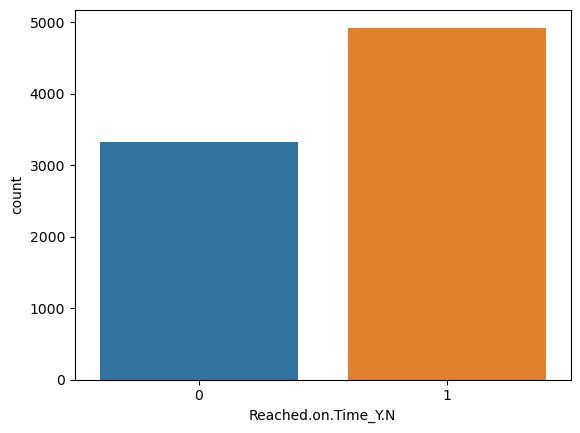

In [23]:
# 종속변수 클래스 분포 시각화
sns.countplot(x = "Reached.on.Time_Y.N", data = y_train)
plt.show()

In [24]:
y_train.value_counts()

Reached.on.Time_Y.N
1                      4922
0                      3327
Name: count, dtype: int64

In [25]:
# 임시 변수명 적용
x_train_re = x_train.copy()
y_train_re = y_train.copy()

x_tmp_name = [f"X{i}" for i in range(1, 17)]
y_tmp_name = ["y1"]

In [26]:
x_train_re.columns = x_tmp_name
y_train_re.columns = y_tmp_name

In [27]:
x_train_re.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16
6910,0.256592,0.5,1.0,0.317073,2.0,0.500000,-0.802056,0,1,0,0,0,1,0,1,1
3639,-0.338243,0.5,-0.5,0.548780,-1.0,-1.000000,0.142657,1,0,0,0,0,1,0,1,1
10735,0.952173,0.0,0.5,0.182927,3.0,0.166667,-0.926335,0,0,0,1,0,1,0,1,0
5276,-0.040553,1.0,1.0,0.975610,1.0,-0.500000,-0.886778,0,0,0,0,0,1,1,0,1
9558,0.738134,-0.5,1.0,-0.695122,1.0,-0.833333,0.152936,0,0,1,0,0,1,0,1,0


In [28]:
# 언더샘플링 적용
x_train_under, y_train_under = RandomUnderSampler(random_state = 43).fit_resample(
x_train_re, y_train_re)

In [29]:
print("랜덤샘플러 적용 전", x_train_re.shape, y_train_re.shape)
print("랜덤샘플러 적용 후", x_train_under.shape, y_train_under.shape)

랜덤샘플러 적용 전 (8249, 16) (8249, 1)
랜덤샘플러 적용 후 (6654, 16) (6654, 1)


In [30]:
y_train_under.value_counts()

y1
0     3327
1     3327
Name: count, dtype: int64

In [31]:
# 컬럼명 복구
x_train_under.columns = list(x_train)
y_train_under.columns = list(y_train)

In [32]:
x_train_under.head()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F,Mode_of_Shipment_Road,Mode_of_Shipment_Ship,Product_importance_low,Product_importance_medium,Gender_M
0,-0.338243,0.5,-0.5,0.548780,-1.0,-1.000000,0.142657,1,0,0,0,0,1,0,1,1
1,0.952173,0.0,0.5,0.182927,3.0,0.166667,-0.926335,0,0,0,1,0,1,0,1,0
2,-0.040553,1.0,1.0,0.975610,1.0,-0.500000,-0.886778,0,0,0,0,0,1,1,0,1
3,0.738134,-0.5,1.0,-0.695122,1.0,-0.833333,0.152936,0,0,1,0,0,1,0,1,0
4,-0.322604,0.5,-1.0,-0.097561,2.0,-0.833333,0.503660,0,0,0,1,0,1,0,1,1


In [33]:
list(x_train)

['ID',
 'Customer_care_calls',
 'Customer_rating',
 'Cost_of_the_Product',
 'Prior_purchases',
 'Discount_offered',
 'Weight_in_gms',
 'Warehouse_block_B',
 'Warehouse_block_C',
 'Warehouse_block_D',
 'Warehouse_block_F',
 'Mode_of_Shipment_Road',
 'Mode_of_Shipment_Ship',
 'Product_importance_low',
 'Product_importance_medium',
 'Gender_M']

In [34]:
x_train_under.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6654 entries, 0 to 6653
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         6654 non-null   float64
 1   Customer_care_calls        6654 non-null   float64
 2   Customer_rating            6654 non-null   float64
 3   Cost_of_the_Product        6654 non-null   float64
 4   Prior_purchases            6654 non-null   float64
 5   Discount_offered           6654 non-null   float64
 6   Weight_in_gms              6654 non-null   float64
 7   Warehouse_block_B          6654 non-null   int64  
 8   Warehouse_block_C          6654 non-null   int64  
 9   Warehouse_block_D          6654 non-null   int64  
 10  Warehouse_block_F          6654 non-null   int64  
 11  Mode_of_Shipment_Road      6654 non-null   int64  
 12  Mode_of_Shipment_Ship      6654 non-null   int64  
 13  Product_importance_low     6654 non-null   int64

In [35]:
# 학습셋 모델 학습
logi = LogisticRegression()
logi.fit(x_train_under, y_train_under)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [36]:
print(logi.score(x_train_under, y_train_under))
print(logi.score(x_test, y_test))

0.7000300571085062
0.6687272727272727


In [55]:
pred = logi.predict_proba(x_test)
pred

array([[0.5579758 , 0.4420242 ],
       [0.81001367, 0.18998633],
       [0.54616692, 0.45383308],
       ...,
       [0.76285422, 0.23714578],
       [0.75766273, 0.24233727],
       [0.83412923, 0.16587077]])

In [56]:
roc_auc_score(y_test,pred[:,1])

0.7403945009228685

# 데이터셋 분할

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


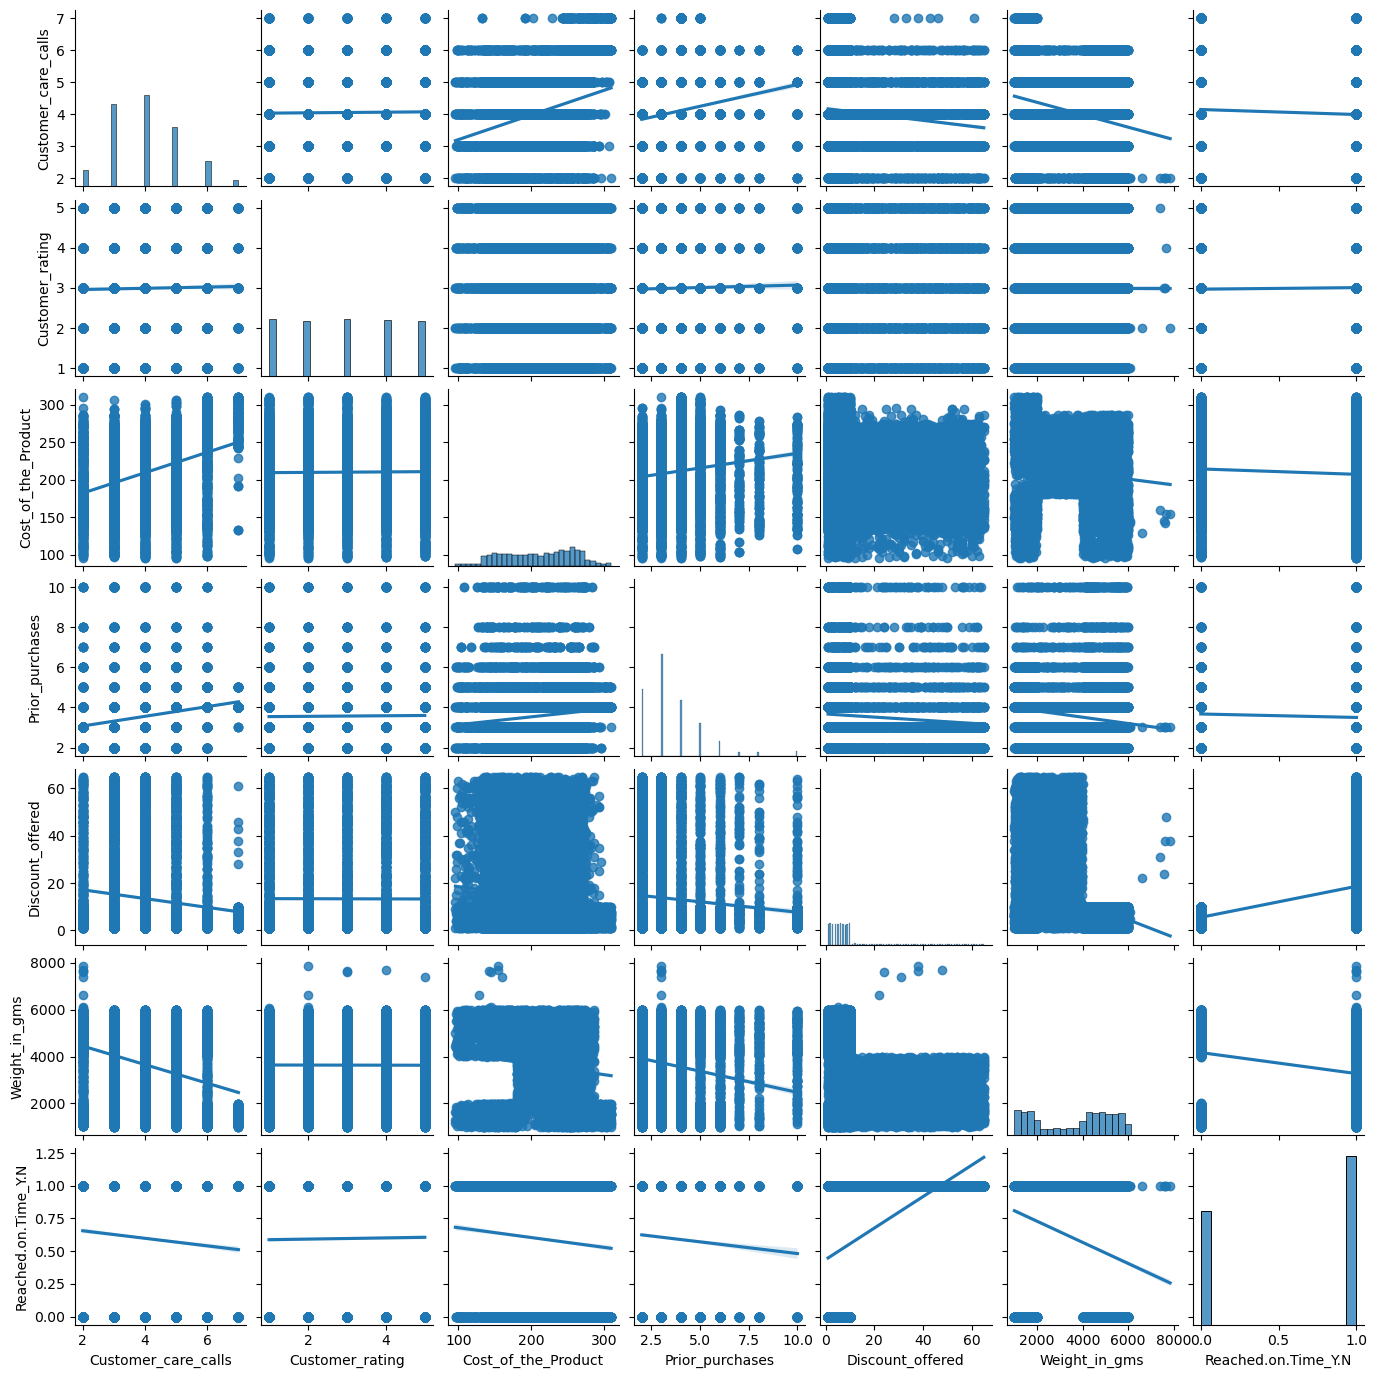

In [61]:
sns.pairplot(df.drop(["ID", "Warehouse_block", "Mode_of_Shipment", "Product_importance", "Gender"], axis = 1), kind='reg', height = 2)

In [69]:
df_corr = df[["Customer_care_calls", "Customer_rating", "Cost_of_the_Product", "Discount_offered", "Weight_in_gms", "Prior_purchases", "Reached.on.Time_Y.N"]].corr()
df_corr

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Discount_offered,Weight_in_gms,Prior_purchases,Reached.on.Time_Y.N
Customer_care_calls,1.000000,0.012209,0.323182,-0.130750,-0.276615,0.180771,-0.067126
Customer_rating,0.012209,1.000000,0.009270,-0.003124,-0.001897,0.013179,0.013119
Cost_of_the_Product,0.323182,0.009270,1.000000,-0.138312,-0.132604,0.123676,-0.073587
Discount_offered,-0.130750,-0.003124,-0.138312,1.000000,-0.376067,-0.082769,0.397108
Weight_in_gms,-0.276615,-0.001897,-0.132604,-0.376067,1.000000,-0.168213,-0.268793
Prior_purchases,0.180771,0.013179,0.123676,-0.082769,-0.168213,1.000000,-0.055515
Reached.on.Time_Y.N,-0.067126,0.013119,-0.073587,0.397108,-0.268793,-0.055515,1.000000


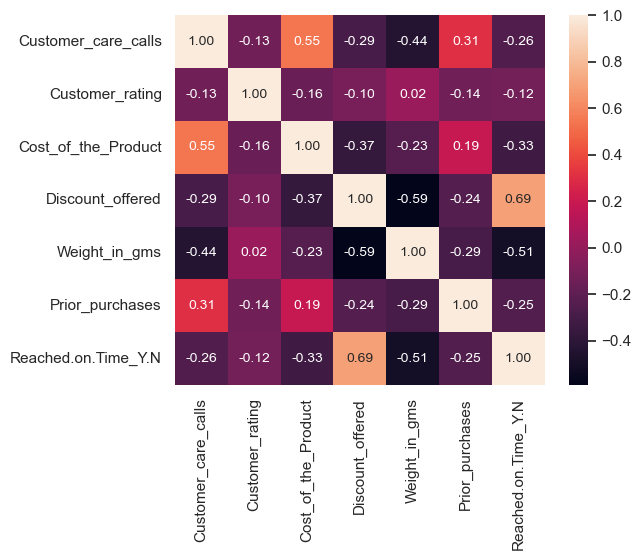

In [70]:
corr_mat = np.corrcoef(df_corr.values.T)
sns.set()
full_mat = sns.heatmap(corr_mat, cbar = True, annot = True, square = True, fmt = ".2f",
                      annot_kws = {"size" : 10}, yticklabels = df_corr,
                      xticklabels = df_corr)
plt.show()

In [72]:
new_df = df[["Customer_care_calls", "Customer_rating", "Discount_offered", "Prior_purchases"]].corr()
new_df.head()

,Customer_care_calls,Customer_rating,Discount_offered,Prior_purchases
Customer_care_calls,1.000000,0.012209,-0.130750,0.180771
Customer_rating,0.012209,1.000000,-0.003124,0.013179
Discount_offered,-0.130750,-0.003124,1.000000,-0.082769
Prior_purchases,0.180771,0.013179,-0.082769,1.000000


In [73]:
new_df.describe()

,Customer_care_calls,Customer_rating,Discount_offered,Prior_purchases
count,4.000000,4.000000,4.000000,4.000000
mean,0.265557,0.255566,0.195839,0.277795
std,0.505912,0.496346,0.538685,0.493633
min,-0.130750,-0.003124,-0.130750,-0.082769
25%,-0.023531,0.008375,-0.094764,-0.010808
50%,0.096490,0.012694,-0.042947,0.096975
75%,0.385578,0.259885,0.247657,0.385578
max,1.000000,1.000000,1.000000,1.000000


# 선형회귀 모델 훈련

In [75]:
x1 = new_df
y1 = y_train_under

In [76]:
# train data와 test data 분할(75 : 25)
x1_train, x1_test, y1_train, y1_test = train_test_split(x, 
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [77]:
print(len(x1_train), len(x1_test))

8249 2750


In [78]:
lr = LinearRegression()

In [79]:
lr.fit(x1_train, y1_train) 

LinearRegression()

# 모델 평가

In [81]:
# 결정계수(R제곱)
r_square = lr.score(x1_test, y1_test)
r_square

0.2163286833073228

In [82]:
# 회귀식의 기울기
lr.coef_

array([[-0.21515216, -0.02437937,  0.01216523, -0.00716391, -0.00796635,
         0.03415665, -0.13112609,  0.02323004,  0.02071408,  0.01348888,
         0.01196706, -0.0106043 , -0.00490479, -0.03233253, -0.0360077 ,
         0.00640862]])

In [83]:
# 회귀식의 y절편
lr.intercept_

array([0.56262678])

In [86]:
# 모형에 x_test를 입력하여 예측한 값을 실제 값과 비교
y1_pred = lr.predict(x1_test)

In [87]:
mse = mean_squared_error(y1_test, y1_pred, squared = True)
mse 

0.18808111600624253

In [97]:
reached_time_pred = pd.DataFrame({"Reached.on.Time_Y.N" : y1_test["Reached.on.Time_Y.N"], "pred" : y1_pred.flatten()})
reached_time_pred

,Reached.on.Time_Y.N,pred
107,1,0.992823
5594,1,0.451661
6997,0,0.463303
3984,0,0.511971
3111,1,0.920216
...,...,...
3944,0,0.552802
10782,1,0.484921
9604,1,0.356944
2513,1,0.973809


In [98]:
reached_time_pred.to_csv("./reached_time_pred.csv")